In [1]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import jax
import cv2
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")

import jax.numpy as jnp
from absl import app, flags
import optax
import json
import numpy as np
from functools import partial
import orbax.checkpoint as ocp
from tensorflow_text import SentencepieceTokenizer
# from palivla.dataset import prepare_image
from palivla.tokenizer import Tokenizer
from palivla.load_model import load_model_params_decode
from scalax.sharding import MeshShardingHelper, FSDPShardingRule, PartitionSpec
from flax.training.train_state import TrainState
from jax.experimental import multihost_utils
from ml_collections import config_flags
from palivla.train_state import PaliVLATrainState
from palivla.types import TrainingBatch, RolloutBatch

# export TPU_VISIBLE_DEVICES=0 
# export TPU_CHIPS_PER_HOST_BOUNDS=1,1,1 
# export TPU_HOST_BOUNDS=1,1,1 
# export TPU_MESH_CONTROLLER_ADDRESS=localhost:8476 
# export TPU_MESH_CONTROLLER_PORT=8476

os.environ['TPU_VISIBLE_DEVICES'] = '0'
os.environ['TPU_CHIPS_PER_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_MESH_CONTROLLER_ADDRESS'] = 'localhost:8476'
os.environ['TPU_MESH_CONTROLLER_PORT'] = '8476'


/nfs/nfs2/users/mitsuhiko/miniconda/envs/big_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-05 01:08:02.909866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733360882.928725 2267810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733360882.934472 2267810 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 01:08:06.536331: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call 

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [2]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ind = np.random.randint(0, 1000)
ds = builder.as_dataset(split=f'train[{ind}:{ind+1}]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (224, 224)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: Move the yellow cloth behind the pot


In [3]:


# action_mean = np.array(dataset_statistics[dataset_name]["action"]["mean"])
# action_std = np.array(dataset_statistics[dataset_name]["action"]["std"])
# action_mask = np.array(dataset_statistics[dataset_name]["action"]["mask"])
def make_inference_batch(batch):
    sensors = {
        k: batch["observation"][k][None].numpy()
        for k in batch["observation"]
        if k in model.model_state.model.modality_mappings and k != "text"
    }
    sensors_mask = {
        k: batch["observation"]["pad_mask_dict"][k].numpy()
        for k in model.model_state.model.modality_mappings
        if k != "text"
    }
    return RolloutBatch(
            sensor_data=sensors,
            sensor_masks=sensors_mask,
            prompt=batch["tokens"][None].numpy(),
            prompt_mask=batch["mask_input"][None].numpy(),
            prompt_ar=np.zeros_like(batch["mask_ar"][None]),
        )
    

# Do inference
def do_inference(images, instructions):
    data = {
        "observation": {"image_primary": images, "pad_mask_dict": {"image_primary": tf.ones(len(images), dtype=tf.bool)}},
        "task": {"language_instruction": instructions},
    }
    language_token_instructions = tokenizer.tokenize_language_instruction(data)
    # batch = prepare_image(batch)
    batch = tokenizer.prepare_tokens_for_generation(data, language_token_instructions)
    batch = batch | data
    rollout_batch = make_inference_batch(batch)

    out_tokens, value = decode(
        rollout_batch, None
    )
    out_tokens = jax.device_get(multihost_utils.process_allgather(out_tokens))
    value = jax.device_get(multihost_utils.process_allgather(value))
    decoded_actions = tokenizer.detokenize_action(out_tokens)

    # Re-normalize actions using dataset statistics
    # decoded_actions = decoded_actions * action_std + action_mean
    # decoded_actions = unnormalize_action(decoded_actions, dataset_statistics[dataset_name]["action"])
    decoded_actions = unnormalize_action_minmax(decoded_actions, dataset_statistics[dataset_name]["action"])

    return decoded_actions, value

def unnormalize_action(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action * unnormalization_statistics["std"])
        + unnormalization_statistics["mean"],
        action,
    )
    return action

def unnormalize_action_minmax(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action + 1) / 2 * (unnormalization_statistics["p99"] - unnormalization_statistics["p01"]) + unnormalization_statistics["p01"],
        action,
    )

    return action

In [4]:
resume_from_checkpoint_dir = "gs://rail-tpus-mitsuhiko-central2/logs/test/pleasant-disco-52/"
# resume_from_checkpoint_step = "gs://rail-tpus-mitsuhiko-central2/logs/test/bright-thunder-2/"
resume_from_checkpoint_step = 100000
dataset_name = "bridge_dataset"

In [5]:
# Sharding
mesh = MeshShardingHelper([-1], ["fsdp"])

model_sharding = FSDPShardingRule("fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"])
data_sharding = PartitionSpec("fsdp")
# data_sharding = jax.sharding.SingleDeviceSharding(jax.local_devices()[0])

restore_checkpoint_manager = ocp.CheckpointManager(
        resume_from_checkpoint_dir,
        item_handlers=PaliVLATrainState.get_checkpoint_handlers(),
)

model = PaliVLATrainState.restore(
        checkpoint_manager=restore_checkpoint_manager,
        step=resume_from_checkpoint_step,
        load_optimizer=False,
        mesh=mesh,
        model_sharding=model_sharding,
        data_sharding=data_sharding,
    )
tokenizer = model.tokenizer
decode = model.decode
dataset_statistics = model.dataset_statistics


I1205 01:08:17.625621 2270726 google_auth_provider.cc:181] Running on GCE, using service account 180902422847-compute@developer.gserviceaccount.com
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [6]:
tokenizer

Tokenizer(config=Tokenizer.TokenizerConfig(action_vocab_size=256, action_vocab_offset=256000, vocab_size=<bound method SentencepieceTokenizer.vocab_size of <tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7f06b003be80>>, num_action_tokens=7, bos_token=2, eos_token=1, pad_token=0, begin_of_action_token=108, end_of_action_token=3, max_pad_length=60, min_action_value=-2, max_action_value=2, prompt_autoregressive=False), language_tokenizer=<tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7f06b003be80>, token_structure=FrozenDict({
    causal: ('action', (3,)),
    pad: ((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),),
    prefix: ((2,), 'prompt', (108,)),
}), action_tokenizer=BinActionTokenizer(
    # attributes
    min_action_value = -2
    max_action_value = 2
    action_dim = 7
 

## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [7]:
WINDOW_SIZE = 1
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
pred_values = []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_image = images[step][None]
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1.0
    instruction = tf.constant(language_instruction)
    
    actions, value = do_inference(input_image, instruction)
    print(value, actions)
    pred_actions.append(actions)
    pred_values.append(value)

    true_actions.append(np.concatenate(
        (
            steps[step]['action']['world_vector'], 
            steps[step]['action']['rotation_delta'], 
            np.array(steps[step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

  0%|          | 0/42 [00:00<?, ?it/s]

0 [[256128]]
0 -16.094734
1 [[256128]]
1 -12.874098
2 [[256114]]
2 -20.254335
3 [[256127]]
3 -16.646502
4 [[256133]]
4 -17.935986
5 [[256129]]
5 -9.826219
6 [[256192]]
6 -8.918054
7 [[3]]
7 -12.04654


  2%|▏         | 1/42 [00:06<04:38,  6.79s/it]

[array(-16.094734, dtype=float32), array(-12.874098, dtype=float32), array(-20.254335, dtype=float32), array(-16.646502, dtype=float32), array(-17.935986, dtype=float32), array(-9.826219, dtype=float32), array(-8.918054, dtype=float32), array(-12.04654, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04  1.5117377e-03  1.0000000e+00]]]
0 [[256128]]
0 -16.092571
1 [[256128]]
1 -12.930913
2 [[256114]]
2 -20.226295
3 [[256127]]
3 -16.692123
4 [[256133]]
4 -17.99622
5 [[256129]]
5 -9.856877
6 [[256192]]
6 -8.911757
7 [[3]]


  5%|▍         | 2/42 [00:07<01:57,  2.93s/it]

7 -12.033197
[array(-16.092571, dtype=float32), array(-12.930913, dtype=float32), array(-20.226295, dtype=float32), array(-16.692123, dtype=float32), array(-17.99622, dtype=float32), array(-9.856877, dtype=float32), array(-8.911757, dtype=float32), array(-12.033197, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04  1.5117377e-03  1.0000000e+00]]]
0 [[256128]]
0 -16.558943
1 [[256128]]
1 -19.495443
2 [[256114]]
2 -17.220085
3 [[256127]]
3 -15.06826
4 [[256133]]
4 -18.142502
5 [[256128]]
5 -4.857763
6 [[256192]]


  7%|▋         | 3/42 [00:07<01:06,  1.69s/it]

6 -2.8634121
7 [[3]]
7 -4.6879635
[array(-16.558943, dtype=float32), array(-19.495443, dtype=float32), array(-17.220085, dtype=float32), array(-15.06826, dtype=float32), array(-18.142502, dtype=float32), array(-4.857763, dtype=float32), array(-2.8634121, dtype=float32), array(-4.6879635, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -18.634378
1 [[256128]]
1 -19.637451
2 [[256114]]
2 -19.251131
3 [[256127]]
3 -15.008693
4 [[256133]]
4 -17.845583
5 [[256128]]


 10%|▉         | 4/42 [00:07<00:42,  1.11s/it]

5 -3.50291
6 [[256192]]
6 -1.8678644
7 [[3]]
7 -3.831543
[array(-18.634378, dtype=float32), array(-19.637451, dtype=float32), array(-19.251131, dtype=float32), array(-15.008693, dtype=float32), array(-17.845583, dtype=float32), array(-3.50291, dtype=float32), array(-1.8678644, dtype=float32), array(-3.831543, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256096]]
0 -16.869
1 [[256136]]
1 -17.732462
2 [[256094]]
2 -16.85256
3 [[256135]]
3 -17.213713
4 [[256144]]


 12%|█▏        | 5/42 [00:07<00:29,  1.26it/s]

4 -16.70198
5 [[256125]]
5 -11.312219
6 [[256192]]
6 -9.099763
7 [[3]]
7 -12.088629
[array(-16.869, dtype=float32), array(-17.732462, dtype=float32), array(-16.85256, dtype=float32), array(-17.213713, dtype=float32), array(-16.70198, dtype=float32), array(-11.312219, dtype=float32), array(-9.099763, dtype=float32), array(-12.088629, dtype=float32)] [[[-0.0143741   0.00472803 -0.01052591  0.00933324  0.0137284
   -0.01122659  1.        ]]]
0 [[256128]]
0 -15.776046
1 [[256128]]
1 -16.348133
2 [[256114]]
2 -16.596548
3 [[256127]]


 14%|█▍        | 6/42 [00:07<00:21,  1.67it/s]

3 -16.516638
4 [[256133]]
4 -18.716791
5 [[256128]]
5 -6.6522093
6 [[256192]]
6 -3.7131157
7 [[3]]
7 -6.174731
[array(-15.776046, dtype=float32), array(-16.348133, dtype=float32), array(-16.596548, dtype=float32), array(-16.516638, dtype=float32), array(-18.716791, dtype=float32), array(-6.6522093, dtype=float32), array(-3.7131157, dtype=float32), array(-6.174731, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -15.75324
1 [[256128]]
1 -15.914613
2 [[256081]]


 17%|█▋        | 7/42 [00:08<00:16,  2.09it/s]

2 -18.09689
3 [[256129]]
3 -17.675238
4 [[256147]]
4 -17.76
5 [[256128]]
5 -11.405702
6 [[256192]]
6 -9.14231
7 [[3]]
7 -12.644887
[array(-15.75324, dtype=float32), array(-15.914613, dtype=float32), array(-18.09689, dtype=float32), array(-17.675238, dtype=float32), array(-17.76, dtype=float32), array(-11.405702, dtype=float32), array(-9.14231, dtype=float32), array(-12.644887, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -1.7221551e-02  1.7663017e-03
    1.7698109e-02 -1.6728491e-03  1.0000000e+00]]]
0 [[256135]]
0 -16.136728
1 [[256128]]


 19%|█▉        | 8/42 [00:08<00:13,  2.52it/s]

1 -17.636606
2 [[256083]]
2 -18.410503
3 [[256128]]
3 -18.080534
4 [[256147]]
4 -17.998037
5 [[256129]]
5 -12.164498
6 [[256192]]
6 -9.00716
7 [[3]]
7 -12.699397
[array(-16.136728, dtype=float32), array(-17.636606, dtype=float32), array(-18.410503, dtype=float32), array(-18.080534, dtype=float32), array(-17.998037, dtype=float32), array(-12.164498, dtype=float32), array(-9.00716, dtype=float32), array(-12.699397, dtype=float32)] [[[ 2.8900541e-03 -4.0086359e-04 -1.6191453e-02  5.0514191e-04
    1.7698109e-02  1.5117377e-03  1.0000000e+00]]]
0 [[256132]]


 21%|██▏       | 9/42 [00:08<00:11,  2.92it/s]

0 -15.915503
1 [[256128]]
1 -16.453924
2 [[256083]]
2 -18.184227
3 [[256128]]
3 -17.766249
4 [[256147]]
4 -17.886883
5 [[256128]]
5 -12.135208
6 [[256192]]
6 -9.153034
7 [[3]]
7 -12.688703
[array(-15.915503, dtype=float32), array(-16.453924, dtype=float32), array(-18.184227, dtype=float32), array(-17.766249, dtype=float32), array(-17.886883, dtype=float32), array(-12.135208, dtype=float32), array(-9.153034, dtype=float32), array(-12.688703, dtype=float32)] [[[ 1.5620440e-03 -4.0086359e-04 -1.6191453e-02  5.0514191e-04
    1.7698109e-02 -1.6728491e-03  1.0000000e+00]]]


 24%|██▍       | 10/42 [00:08<00:09,  3.26it/s]

0 [[256133]]
0 -16.410303
1 [[256128]]
1 -16.594482
2 [[256083]]
2 -18.269438
3 [[256127]]
3 -17.943213
4 [[256149]]
4 -17.861635
5 [[256128]]
5 -12.866595
6 [[256192]]
6 -9.161006
7 [[3]]
7 -12.806036
[array(-16.410303, dtype=float32), array(-16.594482, dtype=float32), array(-18.269438, dtype=float32), array(-17.943213, dtype=float32), array(-17.861635, dtype=float32), array(-12.866595, dtype=float32), array(-9.161006, dtype=float32), array(-12.806036, dtype=float32)] [[[ 2.0047147e-03 -4.0086359e-04 -1.6191453e-02 -7.5601786e-04
    2.0344578e-02 -1.6728491e-03  1.0000000e+00]]]


 26%|██▌       | 11/42 [00:09<00:08,  3.56it/s]

0 [[256128]]
0 -15.7527895
1 [[256128]]
1 -15.157687
2 [[256088]]
2 -17.114264
3 [[256127]]
3 -16.934443
4 [[256149]]
4 -17.452114
5 [[256128]]
5 -12.065628
6 [[256192]]
6 -9.103772
7 [[3]]
7 -12.188048
[array(-15.7527895, dtype=float32), array(-15.157687, dtype=float32), array(-17.114264, dtype=float32), array(-16.934443, dtype=float32), array(-17.452114, dtype=float32), array(-12.065628, dtype=float32), array(-9.103772, dtype=float32), array(-12.188048, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -1.3616208e-02 -7.5601786e-04
    2.0344578e-02 -1.6728491e-03  1.0000000e+00]]]


 29%|██▊       | 12/42 [00:09<00:07,  3.79it/s]

0 [[256130]]
0 -15.275772
1 [[256128]]
1 -14.706986
2 [[256089]]
2 -17.113504
3 [[256127]]
3 -16.61305
4 [[256147]]
4 -17.578478
5 [[256128]]
5 -12.263305
6 [[256192]]
6 -8.728191
7 [[3]]
7 -11.8652115
[array(-15.275772, dtype=float32), array(-14.706986, dtype=float32), array(-17.113504, dtype=float32), array(-16.61305, dtype=float32), array(-17.578478, dtype=float32), array(-12.263305, dtype=float32), array(-8.728191, dtype=float32), array(-11.8652115, dtype=float32)] [[[ 6.7670271e-04 -4.0086359e-04 -1.3101159e-02 -7.5601786e-04
    1.7698109e-02 -1.6728491e-03  1.0000000e+00]]]


 31%|███       | 13/42 [00:09<00:07,  3.97it/s]

0 [[256130]]
0 -15.923721
1 [[256128]]
1 -17.44241
2 [[256101]]
2 -16.872002
3 [[256127]]
3 -15.816931
4 [[256139]]
4 -17.356792
5 [[256128]]
5 -10.56576
6 [[256192]]
6 -7.5429525
7 [[3]]
7 -9.816203
[array(-15.923721, dtype=float32), array(-17.44241, dtype=float32), array(-16.872002, dtype=float32), array(-15.816931, dtype=float32), array(-17.356792, dtype=float32), array(-10.56576, dtype=float32), array(-7.5429525, dtype=float32), array(-9.816203, dtype=float32)] [[[ 6.7670271e-04 -4.0086359e-04 -6.9205705e-03 -7.5601786e-04
    7.1122050e-03 -1.6728491e-03  1.0000000e+00]]]


 33%|███▎      | 14/42 [00:09<00:06,  4.11it/s]

0 [[256128]]
0 -17.549227
1 [[256128]]
1 -18.816193
2 [[256114]]
2 -18.243837
3 [[256127]]
3 -15.849344
4 [[256133]]
4 -17.348356
5 [[256128]]
5 -7.5577035
6 [[256192]]
6 -5.267038
7 [[3]]
7 -6.5034404
[array(-17.549227, dtype=float32), array(-18.816193, dtype=float32), array(-18.243837, dtype=float32), array(-15.849344, dtype=float32), array(-17.348356, dtype=float32), array(-7.5577035, dtype=float32), array(-5.267038, dtype=float32), array(-6.5034404, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 36%|███▌      | 15/42 [00:09<00:06,  4.20it/s]

0 [[256166]]
0 -17.910467
1 [[256123]]
1 -17.007723
2 [[256114]]
2 -19.60006
3 [[256125]]
3 -18.961111
4 [[256128]]
4 -18.789341
5 [[256129]]
5 -12.342098
6 [[256192]]
6 -8.545143
7 [[3]]
7 -12.10652
[array(-17.910467, dtype=float32), array(-17.007723, dtype=float32), array(-19.60006, dtype=float32), array(-18.961111, dtype=float32), array(-18.789341, dtype=float32), array(-12.342098, dtype=float32), array(-8.545143, dtype=float32), array(-12.10652, dtype=float32)] [[[ 1.6612843e-02 -3.6064237e-03 -2.2493303e-04 -3.2783300e-03
   -7.4434057e-03  1.5117377e-03  1.0000000e+00]]]


 38%|███▊      | 16/42 [00:10<00:06,  4.27it/s]

0 [[256166]]
0 -16.678892
1 [[256128]]
1 -17.161745
2 [[256114]]
2 -19.698088
3 [[256127]]
3 -18.976942
4 [[256129]]
4 -18.73159
5 [[256129]]
5 -11.326406
6 [[256192]]
6 -8.650899
7 [[3]]
7 -11.969547
[array(-16.678892, dtype=float32), array(-17.161745, dtype=float32), array(-19.698088, dtype=float32), array(-18.976942, dtype=float32), array(-18.73159, dtype=float32), array(-11.326406, dtype=float32), array(-8.650899, dtype=float32), array(-11.969547, dtype=float32)] [[[ 1.6612843e-02 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -6.1201677e-03  1.5117377e-03  1.0000000e+00]]]


 40%|████      | 17/42 [00:10<00:05,  4.33it/s]

0 [[256166]]
0 -17.372597
1 [[256125]]
1 -16.88277
2 [[256114]]
2 -19.343327
3 [[256126]]
3 -18.630861
4 [[256129]]
4 -18.46486
5 [[256129]]
5 -11.893161
6 [[256192]]
6 -8.414635
7 [[3]]
7 -11.6976185
[array(-17.372597, dtype=float32), array(-16.88277, dtype=float32), array(-19.343327, dtype=float32), array(-18.630861, dtype=float32), array(-18.46486, dtype=float32), array(-11.893161, dtype=float32), array(-8.414635, dtype=float32), array(-11.6976185, dtype=float32)] [[[ 1.6612843e-02 -2.3242012e-03 -2.2493303e-04 -2.0171702e-03
   -6.1201677e-03  1.5117377e-03  1.0000000e+00]]]


 43%|████▎     | 18/42 [00:10<00:05,  4.37it/s]

0 [[256166]]
0 -17.657814
1 [[256125]]
1 -17.417044
2 [[256114]]
2 -18.964249
3 [[256126]]
3 -18.38935
4 [[256129]]
4 -18.158825
5 [[256129]]
5 -11.398051
6 [[256192]]
6 -8.222491
7 [[3]]
7 -11.742681
[array(-17.657814, dtype=float32), array(-17.417044, dtype=float32), array(-18.964249, dtype=float32), array(-18.38935, dtype=float32), array(-18.158825, dtype=float32), array(-11.398051, dtype=float32), array(-8.222491, dtype=float32), array(-11.742681, dtype=float32)] [[[ 1.6612843e-02 -2.3242012e-03 -2.2493303e-04 -2.0171702e-03
   -6.1201677e-03  1.5117377e-03  1.0000000e+00]]]


 45%|████▌     | 19/42 [00:10<00:05,  4.40it/s]

0 [[256164]]
0 -17.588043
1 [[256128]]
1 -15.456578
2 [[256114]]
2 -18.724762
3 [[256126]]
3 -17.967886
4 [[256129]]
4 -17.976383
5 [[256129]]
5 -10.982595
6 [[256192]]
6 -7.9224787
7 [[3]]
7 -10.687907
[array(-17.588043, dtype=float32), array(-15.456578, dtype=float32), array(-18.724762, dtype=float32), array(-17.967886, dtype=float32), array(-17.976383, dtype=float32), array(-10.982595, dtype=float32), array(-7.9224787, dtype=float32), array(-10.687907, dtype=float32)] [[[ 1.5727501e-02 -4.0086359e-04 -2.2493303e-04 -2.0171702e-03
   -6.1201677e-03  1.5117377e-03  1.0000000e+00]]]


 48%|████▊     | 20/42 [00:11<00:04,  4.41it/s]

0 [[256159]]
0 -14.724797
1 [[256142]]
1 -14.556795
2 [[256114]]
2 -18.661282
3 [[256128]]
3 -18.10285
4 [[256129]]
4 -15.67432
5 [[256135]]
5 -9.9766445
6 [[256192]]
6 -8.679717
7 [[3]]
7 -11.319596
[array(-14.724797, dtype=float32), array(-14.556795, dtype=float32), array(-18.661282, dtype=float32), array(-18.10285, dtype=float32), array(-15.67432, dtype=float32), array(-9.9766445, dtype=float32), array(-8.679717, dtype=float32), array(-11.319596, dtype=float32)] [[[ 1.3514150e-02  8.5747093e-03 -2.2493303e-04  5.0514191e-04
   -6.1201677e-03  2.0619228e-02  1.0000000e+00]]]


 50%|█████     | 21/42 [00:11<00:04,  4.43it/s]

0 [[256128]]
0 -16.734524
1 [[256128]]
1 -16.420685
2 [[256114]]
2 -17.36634
3 [[256127]]
3 -14.806746
4 [[256133]]
4 -16.97114
5 [[256128]]
5 -5.2175508
6 [[256192]]
6 -4.2647667
7 [[3]]
7 -5.4492717
[array(-16.734524, dtype=float32), array(-16.420685, dtype=float32), array(-17.36634, dtype=float32), array(-14.806746, dtype=float32), array(-16.97114, dtype=float32), array(-5.2175508, dtype=float32), array(-4.2647667, dtype=float32), array(-5.4492717, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 52%|█████▏    | 22/42 [00:11<00:04,  4.43it/s]

0 [[256128]]
0 -16.676865
1 [[256128]]
1 -17.398096
2 [[256114]]
2 -17.461266
3 [[256127]]
3 -14.55642
4 [[256133]]
4 -15.512029
5 [[256128]]
5 -5.032044
6 [[256192]]
6 -4.295795
7 [[3]]
7 -5.3178287
[array(-16.676865, dtype=float32), array(-17.398096, dtype=float32), array(-17.461266, dtype=float32), array(-14.55642, dtype=float32), array(-15.512029, dtype=float32), array(-5.032044, dtype=float32), array(-4.295795, dtype=float32), array(-5.3178287, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 55%|█████▍    | 23/42 [00:11<00:04,  4.41it/s]

0 [[256127]]
0 -14.438521
1 [[256157]]
1 -13.482193
2 [[256114]]
2 -17.773947
3 [[256129]]
3 -16.124851
4 [[256134]]
4 -12.903578
5 [[256140]]
5 -8.943383
6 [[256192]]
6 -8.603347
7 [[3]]
7 -10.686139
[array(-14.438521, dtype=float32), array(-13.482193, dtype=float32), array(-17.773947, dtype=float32), array(-16.124851, dtype=float32), array(-12.903578, dtype=float32), array(-8.943383, dtype=float32), array(-8.603347, dtype=float32), array(-10.686139, dtype=float32)] [[[-6.5130927e-04  1.8191390e-02 -2.2493303e-04  1.7663017e-03
    4.9602240e-04  3.6542147e-02  1.0000000e+00]]]


 57%|█████▋    | 24/42 [00:11<00:04,  4.42it/s]

0 [[256127]]
0 -13.418539
1 [[256158]]
1 -13.254435
2 [[256114]]
2 -17.464777
3 [[256129]]
3 -16.609793
4 [[256133]]
4 -12.913852
5 [[256141]]
5 -8.784177
6 [[256192]]
6 -8.462117
7 [[3]]
7 -10.5325575
[array(-13.418539, dtype=float32), array(-13.254435, dtype=float32), array(-17.464777, dtype=float32), array(-16.609793, dtype=float32), array(-12.913852, dtype=float32), array(-8.784177, dtype=float32), array(-8.462117, dtype=float32), array(-10.5325575, dtype=float32)] [[[-6.5130927e-04  1.8832505e-02 -2.2493303e-04  1.7663017e-03
   -8.2721561e-04  3.9726734e-02  1.0000000e+00]]]


 60%|█████▉    | 25/42 [00:12<00:03,  4.43it/s]

0 [[256128]]
0 -16.360817
1 [[256128]]
1 -17.586079
2 [[256114]]
2 -17.229641
3 [[256127]]
3 -14.241498
4 [[256133]]
4 -14.810088
5 [[256128]]
5 -4.663731
6 [[256192]]
6 -4.4762464
7 [[3]]
7 -5.2815495
[array(-16.360817, dtype=float32), array(-17.586079, dtype=float32), array(-17.229641, dtype=float32), array(-14.241498, dtype=float32), array(-14.810088, dtype=float32), array(-4.663731, dtype=float32), array(-4.4762464, dtype=float32), array(-5.2815495, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 62%|██████▏   | 26/42 [00:12<00:03,  4.44it/s]

0 [[256128]]
0 -17.675611
1 [[256128]]
1 -18.60643
2 [[256114]]
2 -17.92481
3 [[256127]]
3 -14.681314
4 [[256133]]
4 -15.817364
5 [[256128]]
5 -4.9357767
6 [[256192]]
6 -4.5286293
7 [[3]]
7 -5.5263724
[array(-17.675611, dtype=float32), array(-18.60643, dtype=float32), array(-17.92481, dtype=float32), array(-14.681314, dtype=float32), array(-15.817364, dtype=float32), array(-4.9357767, dtype=float32), array(-4.5286293, dtype=float32), array(-5.5263724, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 64%|██████▍   | 27/42 [00:12<00:03,  4.44it/s]

0 [[256128]]
0 -18.312132
1 [[256128]]
1 -18.081182
2 [[256114]]
2 -17.799301
3 [[256127]]
3 -14.80017
4 [[256133]]
4 -15.824025
5 [[256128]]
5 -5.159373
6 [[256192]]
6 -4.5606923
7 [[3]]
7 -5.4478903
[array(-18.312132, dtype=float32), array(-18.081182, dtype=float32), array(-17.799301, dtype=float32), array(-14.80017, dtype=float32), array(-15.824025, dtype=float32), array(-5.159373, dtype=float32), array(-4.5606923, dtype=float32), array(-5.4478903, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 67%|██████▋   | 28/42 [00:12<00:03,  4.44it/s]

0 [[256128]]
0 -16.485449
1 [[256128]]
1 -17.410988
2 [[256114]]
2 -16.943233
3 [[256127]]
3 -14.273537
4 [[256133]]
4 -15.058907
5 [[256128]]
5 -5.4976993
6 [[256192]]
6 -4.5886817
7 [[3]]
7 -5.524826
[array(-16.485449, dtype=float32), array(-17.410988, dtype=float32), array(-16.943233, dtype=float32), array(-14.273537, dtype=float32), array(-15.058907, dtype=float32), array(-5.4976993, dtype=float32), array(-4.5886817, dtype=float32), array(-5.524826, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 69%|██████▉   | 29/42 [00:13<00:02,  4.44it/s]

0 [[256128]]
0 -17.286581
1 [[256128]]
1 -16.33646
2 [[256114]]
2 -17.063293
3 [[256127]]
3 -14.726343
4 [[256133]]
4 -16.290533
5 [[256128]]
5 -5.8597302
6 [[256192]]
6 -4.2804594
7 [[3]]
7 -5.6293006
[array(-17.286581, dtype=float32), array(-16.33646, dtype=float32), array(-17.063293, dtype=float32), array(-14.726343, dtype=float32), array(-16.290533, dtype=float32), array(-5.8597302, dtype=float32), array(-4.2804594, dtype=float32), array(-5.6293006, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 71%|███████▏  | 30/42 [00:13<00:02,  4.45it/s]

0 [[256128]]
0 -17.67261
1 [[256128]]
1 -16.716864
2 [[256114]]
2 -17.040901
3 [[256127]]
3 -14.904562
4 [[256133]]
4 -16.377502
5 [[256128]]
5 -5.8227167
6 [[256192]]
6 -4.5428076
7 [[3]]
7 -5.6690288
[array(-17.67261, dtype=float32), array(-16.716864, dtype=float32), array(-17.040901, dtype=float32), array(-14.904562, dtype=float32), array(-16.377502, dtype=float32), array(-5.8227167, dtype=float32), array(-4.5428076, dtype=float32), array(-5.6690288, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 74%|███████▍  | 31/42 [00:13<00:02,  4.44it/s]

0 [[256128]]
0 -17.70911
1 [[256128]]
1 -16.837475
2 [[256114]]
2 -17.350548
3 [[256127]]
3 -14.9216385
4 [[256133]]
4 -16.441502
5 [[256128]]
5 -6.2429986
6 [[256192]]
6 -4.68481
7 [[3]]
7 -5.828702
[array(-17.70911, dtype=float32), array(-16.837475, dtype=float32), array(-17.350548, dtype=float32), array(-14.9216385, dtype=float32), array(-16.441502, dtype=float32), array(-6.2429986, dtype=float32), array(-4.68481, dtype=float32), array(-5.828702, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 76%|███████▌  | 32/42 [00:13<00:02,  4.44it/s]

0 [[256128]]
0 -17.164585
1 [[256128]]
1 -17.052046
2 [[256114]]
2 -17.201897
3 [[256127]]
3 -14.65602
4 [[256133]]
4 -14.586941
5 [[256128]]
5 -6.425514
6 [[256192]]
6 -4.8529377
7 [[3]]
7 -5.9565372
[array(-17.164585, dtype=float32), array(-17.052046, dtype=float32), array(-17.201897, dtype=float32), array(-14.65602, dtype=float32), array(-14.586941, dtype=float32), array(-6.425514, dtype=float32), array(-4.8529377, dtype=float32), array(-5.9565372, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 79%|███████▊  | 33/42 [00:13<00:02,  4.43it/s]

0 [[256130]]
0 -15.1746645
1 [[256128]]
1 -15.606723
2 [[256109]]
2 -16.266726
3 [[256127]]
3 -15.28347
4 [[256134]]
4 -16.990044
5 [[256128]]
5 -8.135458
6 [[256192]]
6 -5.8830633
7 [[3]]
7 -6.8461566
[array(-15.1746645, dtype=float32), array(-15.606723, dtype=float32), array(-16.266726, dtype=float32), array(-15.28347, dtype=float32), array(-16.990044, dtype=float32), array(-8.135458, dtype=float32), array(-5.8830633, dtype=float32), array(-6.8461566, dtype=float32)] [[[ 6.7670271e-04 -4.0086359e-04 -2.8001778e-03 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 81%|████████  | 34/42 [00:14<00:01,  4.44it/s]

0 [[256128]]
0 -14.858474
1 [[256128]]
1 -13.60559
2 [[256106]]
2 -15.927344
3 [[256127]]
3 -14.049688
4 [[256138]]
4 -17.105947
5 [[256128]]
5 -10.222923
6 [[256192]]
6 -6.976608
7 [[3]]
7 -8.137932
[array(-14.858474, dtype=float32), array(-13.60559, dtype=float32), array(-15.927344, dtype=float32), array(-14.049688, dtype=float32), array(-17.105947, dtype=float32), array(-10.222923, dtype=float32), array(-6.976608, dtype=float32), array(-8.137932, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -4.3453258e-03 -7.5601786e-04
    5.7889670e-03 -1.6728491e-03  1.0000000e+00]]]


 83%|████████▎ | 35/42 [00:14<00:01,  4.44it/s]

0 [[256128]]
0 -14.977646
1 [[256128]]
1 -15.060177
2 [[256094]]
2 -16.578442
3 [[256127]]
3 -15.1191845
4 [[256147]]
4 -17.331228
5 [[256128]]
5 -11.651232
6 [[256192]]
6 -8.772123
7 [[3]]
7 -11.332476
[array(-14.977646, dtype=float32), array(-15.060177, dtype=float32), array(-16.578442, dtype=float32), array(-15.1191845, dtype=float32), array(-17.331228, dtype=float32), array(-11.651232, dtype=float32), array(-8.772123, dtype=float32), array(-11.332476, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -1.0525913e-02 -7.5601786e-04
    1.7698109e-02 -1.6728491e-03  1.0000000e+00]]]


 86%|████████▌ | 36/42 [00:14<00:01,  4.44it/s]

0 [[256127]]
0 -14.489171
1 [[256128]]
1 -13.933442
2 [[256157]]
2 -16.67426
3 [[256128]]
3 -16.322647
4 [[256105]]
4 -16.393974
5 [[256130]]
5 -5.5744944
6 [[256192]]
6 -3.4625483
7 [[3]]
7 -6.3789034
[array(-14.489171, dtype=float32), array(-13.933442, dtype=float32), array(-16.67426, dtype=float32), array(-16.322647, dtype=float32), array(-16.393974, dtype=float32), array(-5.5744944, dtype=float32), array(-3.4625483, dtype=float32), array(-6.3789034, dtype=float32)] [[[-6.5130927e-04 -4.0086359e-04  2.1922175e-02  5.0514191e-04
   -3.7877865e-02  4.6963245e-03  1.0000000e+00]]]


 88%|████████▊ | 37/42 [00:14<00:01,  4.45it/s]

0 [[256127]]
0 -14.715094
1 [[256128]]
1 -14.603961
2 [[256114]]
2 -14.180624
3 [[256127]]
3 -13.77883
4 [[256134]]
4 -13.801271
5 [[256128]]
5 -6.59082
6 [[256192]]
6 -4.379817
7 [[3]]
7 -6.1017394
[array(-14.715094, dtype=float32), array(-14.603961, dtype=float32), array(-14.180624, dtype=float32), array(-13.77883, dtype=float32), array(-13.801271, dtype=float32), array(-6.59082, dtype=float32), array(-4.379817, dtype=float32), array(-6.1017394, dtype=float32)] [[[-6.5130927e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 90%|█████████ | 38/42 [00:15<00:00,  4.45it/s]

0 [[256128]]
0 -15.448234
1 [[256128]]
1 -17.717625
2 [[256116]]
2 -15.963412
3 [[256127]]
3 -13.0945
4 [[256131]]
4 -15.874712
5 [[256128]]
5 -4.4321756
6 [[256192]]
6 -3.5669613
7 [[3]]
7 -5.5861936
[array(-15.448234, dtype=float32), array(-17.717625, dtype=float32), array(-15.963412, dtype=float32), array(-13.0945, dtype=float32), array(-15.874712, dtype=float32), array(-4.4321756, dtype=float32), array(-3.5669613, dtype=float32), array(-5.5861936, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04  8.0516562e-04 -7.5601786e-04
   -3.4736916e-03 -1.6728491e-03  1.0000000e+00]]]


 93%|█████████▎| 39/42 [00:15<00:00,  4.45it/s]

0 [[256128]]
0 -16.061125
1 [[256128]]
1 -13.867578
2 [[256114]]
2 -20.091547
3 [[256127]]
3 -16.277756
4 [[256133]]
4 -16.63052
5 [[256128]]
5 -7.15572
6 [[256192]]
6 -5.0797405
7 [[3]]
7 -7.8519835
[array(-16.061125, dtype=float32), array(-13.867578, dtype=float32), array(-20.091547, dtype=float32), array(-16.277756, dtype=float32), array(-16.63052, dtype=float32), array(-7.15572, dtype=float32), array(-5.0797405, dtype=float32), array(-7.8519835, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 95%|█████████▌| 40/42 [00:15<00:00,  4.45it/s]

0 [[256128]]
0 -15.76961
1 [[256128]]
1 -14.018538
2 [[256114]]
2 -20.261648
3 [[256127]]
3 -16.273891
4 [[256133]]
4 -16.903654
5 [[256128]]
5 -8.002973
6 [[256192]]
6 -7.0446296
7 [[3]]
7 -9.581607
[array(-15.76961, dtype=float32), array(-14.018538, dtype=float32), array(-20.261648, dtype=float32), array(-16.273891, dtype=float32), array(-16.903654, dtype=float32), array(-8.002973, dtype=float32), array(-7.0446296, dtype=float32), array(-9.581607, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


 98%|█████████▊| 41/42 [00:15<00:00,  4.44it/s]

0 [[256128]]
0 -15.806693
1 [[256128]]
1 -13.911028
2 [[256114]]
2 -20.20251
3 [[256127]]
3 -16.223757
4 [[256133]]
4 -16.7933
5 [[256128]]
5 -7.715046
6 [[256192]]
6 -6.4178786
7 [[3]]
7 -9.039859
[array(-15.806693, dtype=float32), array(-13.911028, dtype=float32), array(-20.20251, dtype=float32), array(-16.223757, dtype=float32), array(-16.7933, dtype=float32), array(-7.715046, dtype=float32), array(-6.4178786, dtype=float32), array(-9.039859, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


100%|██████████| 42/42 [00:16<00:00,  2.62it/s]

0 [[256128]]
0 -15.86369
1 [[256128]]
1 -13.922987
2 [[256114]]
2 -20.079973
3 [[256127]]
3 -16.144493
4 [[256133]]
4 -16.465796
5 [[256128]]
5 -7.2766314
6 [[256192]]
6 -5.5485787
7 [[3]]
7 -8.15874
[array(-15.86369, dtype=float32), array(-13.922987, dtype=float32), array(-20.079973, dtype=float32), array(-16.144493, dtype=float32), array(-16.465796, dtype=float32), array(-7.2766314, dtype=float32), array(-5.5485787, dtype=float32), array(-8.15874, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
   -8.2721561e-04 -1.6728491e-03  1.0000000e+00]]]


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

/tmp/ipykernel_2267810/1173017816.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


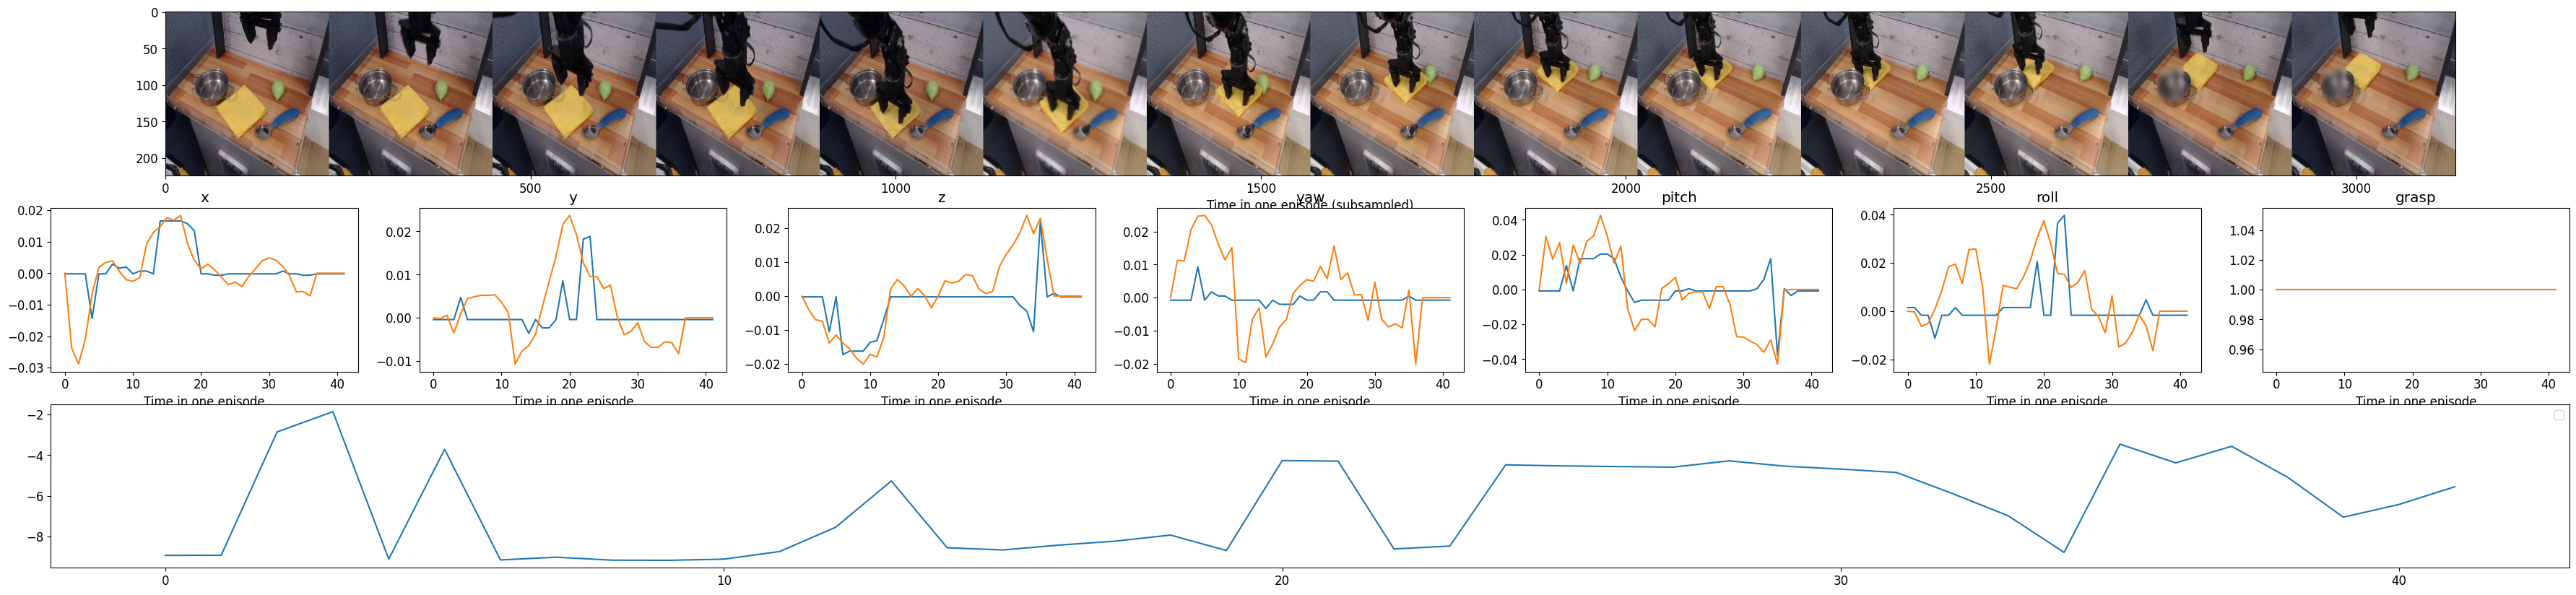

In [8]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS,
    ["value"] * len(ACTION_DIM_LABELS),
    # ["value8"] * len(ACTION_DIM_LABELS),
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()

pred_values = np.array(pred_values).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

# plot value
axs['value'].plot(pred_values[..., -2])
# axs['value8'].plot(pred_values[..., -1])

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()